# Convolutional Neural Networks

# Importar Librerías

In [1]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
!pip install keras

In [3]:
import keras
from keras.utils import to_categorical
from keras import Input, Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D

Vamos a emparejar el notebook de python con el google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Imagenes y píxeles**

La red toma como entrada los pixeles de una imagen. Si tenemos una imagen con apenas 28×28 pixeles de alto y ancho, eso equivale a  784 neuronas. Y eso es si sólo tenemos 1 color (escala de grises). Si tuviéramos una imagen a color, necesitaríamos 3 canales (red, green, blue) y entonces usaríamos 28x28x3 = 2352 neuronas de entrada. Esa es nuestra capa de entrada.

![imagen](https://www.aprendemachinelearning.com/wp-content/uploads/2018/11/cnn-01.png)

### Cargar set de Imágenes

In [5]:
dirname = os.path.join(os.getcwd(), 'drive/MyDrive/DOCENCIA/ANN/sports')
imgpath = dirname + os.sep

In [6]:
images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  /content/drive/MyDrive/DOCENCIA/ANN/sports/
/content/drive/MyDrive/DOCENCIA/ANN/sports/ciclismo 1
/content/drive/MyDrive/DOCENCIA/ANN/sports/f1 1000
/content/drive/MyDrive/DOCENCIA/ANN/sports/futbol 1000
/content/drive/MyDrive/DOCENCIA/ANN/sports/basket 1000
/content/drive/MyDrive/DOCENCIA/ANN/sports/tenis 1000
Directorios leidos: 5
Imagenes en cada directorio [1001, 1000, 1000, 1000, 999]
suma Total de imagenes en subdirs: 5000


# Creamos las etiquetas

In [7]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))

Cantidad etiquetas creadas:  5000


In [8]:
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1

0 ciclismo
1 f1
2 futbol
3 basket
4 tenis


In [9]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy

# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  5
Output classes :  [0 1 2 3 4]


# Creamos Sets de Entrenamiento y Test

In [10]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (4000, 21, 28, 3) (4000,)
Testing data shape :  (1000, 21, 28, 3) (1000,)


Text(0.5, 1.0, 'Ground Truth : 0')

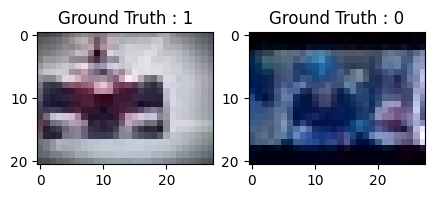

In [11]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Preprocesamos las imagenes

Antes de alimentar la red, recuerda que como entrada nos conviene normalizar los valores. Los colores de los pixeles tienen valores que van de 0 a 255, haremos una transformación de cada pixel: “valor/255” y nos quedará siempre un valor entre 0 y 1.

![imagen2](https://www.aprendemachinelearning.com/wp-content/uploads/2018/11/cnn-02.png)

In [12]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

## Hacemos el One-hot Encoding para la red

In [13]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 1
After conversion to one-hot: [0. 1. 0. 0. 0.]


# Creamos el Set de Entrenamiento y Validación

In [14]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [15]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(3200, 21, 28, 3) (800, 21, 28, 3) (3200, 5) (800, 5)


# **Creamos el modelo de CNN**

Ahora comienza el *procesado distintivo* de las CNN. Es decir, haremos las llamadas *convoluciones*:

Estas consisten en tomar *grupos de pixeles cercanos* de la imagen de entrada e ir operando matemáticamente (producto escalar) contra una pequeña matriz que se llama kernel. Ese kernel supongamos de tamaño 3×3 pixels “recorre” todas las neuronas de entrada (de izquierda-derecha, de arriba-abajo) y genera una nueva matriz de salida, que en definitiva será nuestra nueva capa de neuronas ocultas. NOTA: si la imagen fuera a color, el kernel realmente sería de 3x3x3 es decir: un filtro con 3 kernels de 3×3; luego  esos 3 filtros se suman (y se le suma una unidad bias) y conformarán 1 salida (cómo si fuera 1 solo canal).

![images](https://www.aprendemachinelearning.com/wp-content/uploads/2018/11/cnn-03.png)

# **Filtros:**
## Conjunto de Kernels

Cuando generamos nuestra matriz agregada, en realidad, no aplicaremos 1 sólo kernel, si no que tendremos muchos kernel (en su conjunto se llama filtros). Por ejemplo en esta primer convolución podríamos tener 32 filtros, con lo cual realmente obtendremos 32 matrices de salida (este conjunto se conoce como *feature mapping*), cada una de 28x28x1 dando un total del 25.088 neuronas para nuestra **PRIMER CAPA OCULTA** de neuronas.

\
![imagenes](https://www.aprendemachinelearning.com/wp-content/uploads/2018/11/cnn_kernel.gif)

A medida que vamos desplazando el kernel y vamos obteniendo una *nueva imagen* filtrada por el *kernel*. En esta primer convolución y siguiendo con el ejemplo anterior, es como si obtuviéramos 32 *imágenes filtradas nuevas*. Estas imágenes nuevas lo que están “dibujando” son ciertas características de la imagen original. Esto ayudará en el futuro a poder distinguir un objeto de otro.

![imagen](https://www.aprendemachinelearning.com/wp-content/uploads/2018/11/CNN-04.png)

# **La función de activación**

La función de activación más utilizada para este tipo de redes neuronales es la llamada **ReLu** por *Rectifier Linear Unit* y consiste en f(x) = max(0,x).

# **Subsampling**

Ahora viene un paso en el que reduciremos la cantidad de neuronas antes de hacer una nueva convolución. Estp es debido porque a partir de nuestra imagen blanco y negro de 28x28px tenemos una primer capa de entrada de 784 neuronas y luego de la primer convolución obtenemos una capa oculta de 25.088 neuronas -que realmente son nuestros 32 mapas de características de 28×28-

Si hiciéramos una nueva convolución a partir de esta capa, el número de neuronas de la próxima capa se iría por las nubes (y ello implica mayor procesamiento)! Para reducir el tamaño de la próxima capa de neuronas haremos un proceso de subsampling en el que reduciremos el tamaño de nuestras imágenes filtradas pero en donde deberán prevalecer las características más importantes que detectó cada filtro. Hay diversos tipos de subsampling, a continuación veremos el **más usado**: *Max-Pooling*

## **Max-Pooling**

Vamos a intentar explicarlo con un ejemplo: supongamos que haremos *Max-pooling* de tamaño 2×2. Esto quiere decir que recorreremos cada una de nuestras 32 imágenes de características obtenidas anteriormente de 28x28px de izquierda-derecha, arriba-abajo PERO en vez de tomar de a 1 pixel, tomaremos de “2×2” (2 de alto por 2 de ancho = 4 pixeles) e iremos preservando el valor “más alto” de entre esos 4 pixeles (por eso lo de “Max”). En este caso, usando 2×2, la imagen resultante es reducida “a la mitad”y quedará de 14×14 pixeles. Luego de este proceso de subsamplig nos quedarán  32 imágenes de 14×14, pasando de haber tenido 25.088 neuronas a  6.272, son bastantes menos y -en teoría- siguen almacenando la información más importante para detectar características deseadas.

![Imagen](https://www.aprendemachinelearning.com/wp-content/uploads/2018/11/cnn-05.png)

Muy bien, pues esa ha sido una primer convolución: consiste de una entrada, un conjunto de filtros, generamos un mapa de características y hacemos un subsampling. Con lo cual, en el ejemplo de imágenes de 1 sólo color tendremos:

![Imagen](https://www.aprendemachinelearning.com/wp-content/uploads/2018/11/cnn-06.png)


La **primer convolución** es capaz de detectar características primitivas como lineas ó curvas. A medida que hagamos más capas con las convoluciones, los mapas de características serán capaces de reconocer formas más complejas, y el conjunto total de capas de convoluciones podrá *ver*.

Pues ahora deberemos hacer una Segunda convolución que será:

![Imagen](https://www.aprendemachinelearning.com/wp-content/uploads/2018/11/cnn-07.png)

La **3er convolución** comenzará en tamaño 7×7 pixels y luego del *max-pooling* quedará en 3×3 con lo cual podríamos hacer sólo 1 convolución más. En este ejemplo empezamos con una imagen de 28x28px e hicimos 3 convoluciones. Si la imagen inicial hubiese sido mayor (de 224x224px) aún hubiéramos podido seguir haciendo convoluciones.

Llegamos a la última convolución y nos queda el desenlace…

Para terminar, tomaremos la última capa oculta a la que hicimos *subsampling*, que se dice que es *tridimensional* por tomar la forma -en nuestro ejemplo- 3x3x128 (alto,ancho,mapas) y la *aplanamos*, esto es que deja de ser tridimensional, y pasa a ser una capa de neuronas *tradicionales*, de las que ya conocíamos. Por ejemplo, podríamos aplanar (y conectar) a una nueva capa oculta de 100 neuronas feedforward.

![Imagen](https://www.aprendemachinelearning.com/wp-content/uploads/2018/11/CNN-08.png)

Entonces, a esta nueva capa oculta *tradicional*, le aplicamos una función llamada **Softmax** que conecta contra la capa de salida final que tendrá la cantidad de neuronas correspondientes con las clases que estamos clasificando. Si clasificamos perros y gatos, serán 2 neuronas. Si es el dataset Mnist numérico serán 10 neuronas de salida. Si clasificamos coches, aviones ó barcos serán 3, etc.

Las salidas al momento del entrenamiento tendrán el formato conocido como **one-hot-encoding** en el que para perros y gatos sera: [1,0] y [0,1], para coches, aviones ó barcos será [1,0,0]; [0,1,0];[0,0,1].

Y la función de *Softmax* se encarga de pasar a probabilidad (entre 0 y 1) a las neuronas de salida. Por ejemplo una salida [0,2 0,8] nos indica 20% probabilidades de que sea perro y 80% de que sea gato.

## **Backpropagation**

El proceso es similar al de las redes tradicionales en las que tenemos una entrada y una salida esperada (por eso aprendizaje supervisado) y mediante el *backpropagation* mejoramos el valor de los pesos de las interconexiones entre capas de neuronas y a medida que iteramos esos pesos se ajustan hasta ser óptimos.

En el caso de la CNN, deberemos ajustar el valor de los pesos de los distintos kernels. Esto es una gran ventaja al momento del aprendizaje pues como vimos cada kernel es de un tamaño reducido, en nuestro ejemplo en la primer convolución es de tamaño de 3×3, eso son sólo 9 parámetros que debemos ajustar en 32 filtros dan un total de 288 parámetros. En comparación con los pesos entre dos capas de neuronas “tradicionales”: una de 748 y otra de 6272 en donde están TODAS interconectarlas con TODAS y eso equivaldría a tener que entrenar y ajustar más de 4,5 millones de pesos (repito: sólo para 1 capa).

## **Arquitectura básica**

Resumiendo: podemos decir que los elementos que usamos para crear CNNs son:

- **Entrada:** Serán los pixeles de la imagen. Serán alto, ancho y profundidad será 1 sólo color o 3 para Red,Green,Blue.

- **Capa De Convolución:** procesará la salida de neuronas que están conectadas en “regiones locales” de entrada (es decir pixeles cercanos), calculando el producto escalar entre sus pesos (valor de pixel) y una pequeña región a la que están conectados en el volumen de entrada. Aquí usaremos por ejemplo 32 filtros o la cantidad que decidamos y ese será el volumen de salida.

- **“CAPA RELU”** aplicará la función de activación en los elementos de la matriz.

- **POOL ó SUBSAMPLING:** Hará una reducción en las dimensiones alto y ancho, pero se mantiene la profundidad.

- **CAPA “TRADICIONAL”** red de neuronas feedforward que conectará con la última capa de subsampling y finalizará con la cantidad de neuronas que queremos clasificar.

## Declaración de parámetros

In [29]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 10 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 64 # cantidad de imágenes que se toman a la vez en memoria

## Construcción del modelo

In [18]:
sport_model = Sequential()
sport_model.add(Input(shape = (21, 28, 3)))
sport_model.add(Conv2D(32, kernel_size = (3, 3), activation = 'linear', padding = 'same'))
sport_model.add(LeakyReLU(negative_slope = 0.1))
sport_model.add(MaxPooling2D((2, 2), padding = 'same'))
sport_model.add(Dropout(0.5))
sport_model.add(Flatten())
sport_model.add(Dense(32, activation = 'linear'))
sport_model.add(LeakyReLU(negative_slope = 0.1))
sport_model.add(Dropout(0.5))
sport_model.add(Dense(nClasses, activation = 'softmax'))

In [19]:
sport_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 21, 28, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 21, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 11, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4928)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │         157,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 158,789 (620.27 KB)

 Trainable params: 158,789 (620.27 KB)

 Non-trainable params: 0 (0.00 B)

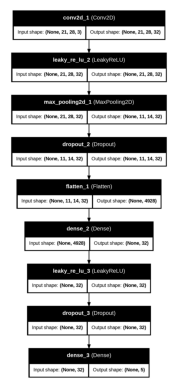

In [22]:
from keras.utils import plot_model

plot_model(sport_model, to_file='modelo_red_neuronal.png', show_shapes = True, show_layer_names = True)

# Mostrar la imagen generada
img = plt.imread('modelo_red_neuronal.png')
plt.imshow(img)
plt.axis('off')  # Opcional: desactivar los ejes
plt.show()

In [26]:
# from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Define un programador de tasa de aprendizaje
lr_schedule = ExponentialDecay(
    initial_learning_rate = INIT_LR,  # Tasa de aprendizaje inicial
    decay_steps = 100,                # Número de pasos para aplicar el decaimiento
    decay_rate = INIT_LR / 100,       # Factor de decaimiento (0.96 es un ejemplo)
    staircase = False                 # `False` para un decaimiento continuo
)


In [27]:
# Compilamos el modelo
sport_model.compile(loss = "categorical_crossentropy",
                    optimizer = Adam(learning_rate = lr_schedule),
                    metrics = ['accuracy'])

# Entrenamos el modelo: Aprende a clasificar imágenes

In [52]:
# este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre
# como ejemplo, en mi Macbook pro tarda 4 minutos
sport_train = sport_model.fit(train_X, train_label, batch_size = batch_size,
                              epochs = epochs, verbose = 1,
                              validation_data = (valid_X, valid_label))

TypeError: 'range' object cannot be interpreted as an integer

In [32]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
nombreFichero = "sports_mnist.keras"  # "sports_mnist.h5"
sport_model.save(nombreFichero)
keras.saving.save_model(sport_model, nombreFichero)

# Evaluamos la red

In [33]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7599 - loss: 1.1284


In [34]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 1.1279338598251343
Test accuracy: 0.777999997138977


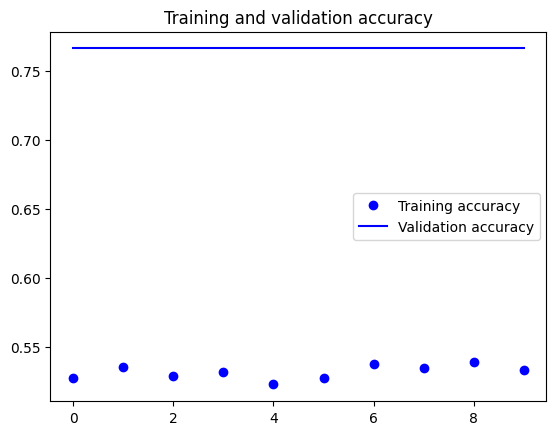

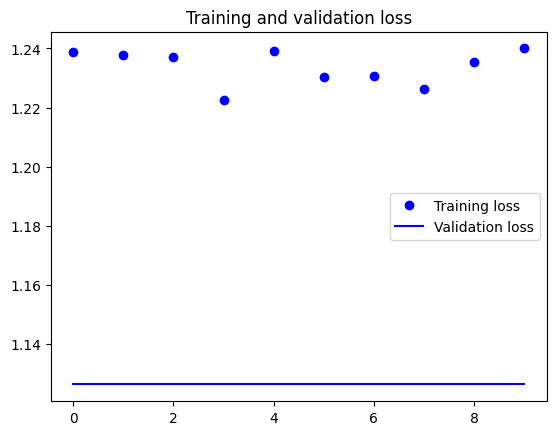

In [36]:
accuracy = sport_train.history['accuracy']
val_accuracy = sport_train.history['val_accuracy']
loss = sport_train.history['loss']
val_loss = sport_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [38]:
predicted_classes2 = sport_model.predict(test_X)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [39]:
predicted_classes = []
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes = np.array(predicted_classes)

In [40]:
predicted_classes.shape, test_Y.shape

((1000,), (1000,))

# Aprendamos de los errores: Qué mejorar

Found 778 correct labels


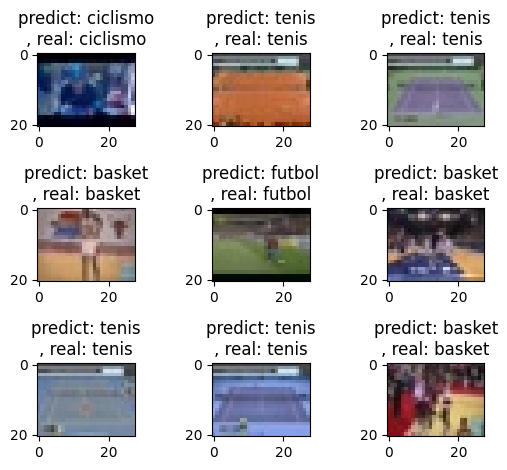

In [41]:
correct = np.where(predicted_classes == test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_X[correct].reshape(21, 28, 3), cmap = 'gray',
               interpolation = 'none')
    plt.title("predict: {}\n real: {}".format(deportes[predicted_classes[correct]],
                                                    deportes[test_Y[correct]]))

    plt.tight_layout()

Found 222 incorrect labels


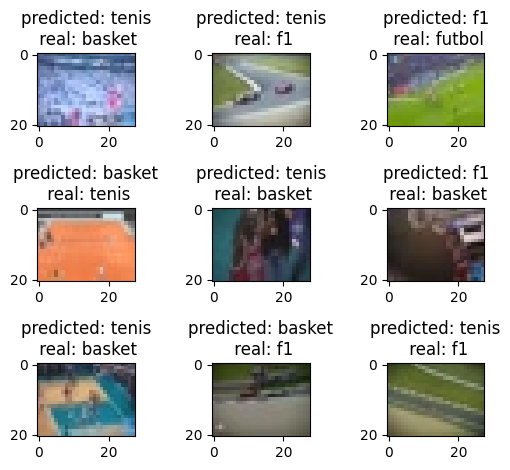

In [42]:
incorrect = np.where(predicted_classes != test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_X[incorrect].reshape(21, 28, 3), cmap = 'gray',
               interpolation = 'none')
    plt.title("predicted: {}\n real: {}".format(deportes[predicted_classes[incorrect]],
                                                    deportes[test_Y[incorrect]]))
    plt.tight_layout()

In [43]:
# target_names = ["Class {}".format(i) for i in range(nClasses)]
target_names = ["ciclismo", "f1", "futbol", "basket", "tenis"]
print(classification_report(test_Y, predicted_classes, target_names = target_names))

              precision    recall  f1-score   support

    ciclismo       0.86      0.99      0.92       181
          f1       0.66      0.63      0.64       200
      futbol       0.98      0.60      0.74       184
      basket       0.77      0.75      0.76       235
       tenis       0.72      0.94      0.81       200

    accuracy                           0.78      1000
   macro avg       0.80      0.78      0.78      1000
weighted avg       0.79      0.78      0.77      1000



# Prediccion de una nueva imagen

In [47]:
from skimage.transform import resize

images = []
# AQUI ESPECIFICAMOS UNAS IMAGENES
filenames = ['/content/drive/MyDrive/DOCENCIA/ANN/sports/test/f12_0096.jpg']

for filepath in filenames:
    image = plt.imread(filepath, 0)
    image_resized = resize(image, (21, 28), anti_aliasing = True, clip = False,
                           preserve_range = True)
    images.append(image_resized)

X = np.array(images, dtype = np.uint8) #convierto de lista a numpy
test_X = X.astype('float32')
test_X = test_X / 255.

predicted_classes = sport_model.predict(test_X)

for i, img_tagged in enumerate(predicted_classes):
    print(filenames[i], deportes[img_tagged.tolist().index(max(img_tagged))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
/content/drive/MyDrive/DOCENCIA/ANN/sports/test/f12_0096.jpg f1


## **TENSORFLOW**

In [53]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

# Definir el callback de TensorBoard
tensorboard_callback = TensorBoard(log_dir="./logs", histogram_freq=1)

In [58]:
# Compilar el modelo
sport_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Entrenar el modelo con el callback
sport_train = sport_model.fit(train_X, train_label, epochs = 10,
                              callbacks = [tensorboard_callback],
                              validation_data = (valid_X, valid_label))

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9707 - loss: 0.0519 - val_accuracy: 0.9900 - val_loss: 0.0153
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9760 - loss: 0.0437 - val_accuracy: 0.9875 - val_loss: 0.0167
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9758 - loss: 0.0464 - val_accuracy: 0.9912 - val_loss: 0.0142
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9744 - loss: 0.0399 - val_accuracy: 0.9900 - val_loss: 0.0144
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9780 - loss: 0.0379 - val_accuracy: 0.9912 - val_loss: 0.0127
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9818 - loss: 0.0367 - val_accuracy: 0.9937 - val_loss: 0.0125
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9846 - loss: 0.0299 - val_accuracy: 0.9950 - val_loss: 0.0110
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9848 - loss: 0.0332 - val_accu

In [59]:
# Crear un callback de TensorBoard
import datetime
log_dir = "/content/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [60]:
# Iniciar TensorBoard en Colab
%load_ext tensorboard
%tensorboard --logdir /content/logs/fit


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 19935), started 0:01:09 ago. (Use '!kill 19935' to kill it.)

<IPython.core.display.Javascript object>